<a href="https://colab.research.google.com/github/gjaegal/gjaegal/blob/main/Unet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import modules & device 설정

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import torch
import shutil

# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

import pandas as pd
import json
import random

import torch
import cv2
import torchvision

import albumentations
import albumentations.pytorch
from torchvision import transforms
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

device:  cuda


# Seed 고정
## 모델 성능 개선을 위해 실행할 때마다 일정한 결과가 도출되도록 한다

In [2]:
seed = 77

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

# Mount drive & unzip

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/kaggle/FloodSegmentation
# !unzip -qq "/content/drive/MyDrive/kaggle/FloodSegmentation.zip"

/content/drive/MyDrive/kaggle/FloodSegmentation


# 데이터 전처리

In [5]:
paths = []
image_list = []
mask_list = []

labels = ['Image', 'Mask']

for label in labels:
  spath = '/content/drive/MyDrive/kaggle/FloodSegmentation/' + label

  if label == 'Image':
    image_list = sorted(os.listdir(spath))
  elif label == 'Mask':
    mask_list = sorted(os.listdir(spath))

df = pd.DataFrame({'image': image_list,'mask': mask_list})
print(df)

        image      mask
0       0.jpg     0.png
1       1.jpg     1.png
2      10.jpg    10.png
3    1000.jpg  1000.png
4    1001.jpg  1001.png
..        ...       ...
285     5.jpg     5.png
286     6.jpg     6.png
287     7.jpg     7.png
288     8.jpg     8.png
289     9.jpg     9.png

[290 rows x 2 columns]


In [6]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

def showImage(image, title=None, cmap=None, alpha=1):
  plt.imshow(image, cmap=cmap, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis('off')

def showMask(image, mask):
  plt.imshow(image, cmap='gray')
  plt.imshow(mask, cmap='jet', alpha=0.4)
  plt.axis('off')

In [7]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# values: df -> numpy (ndarray)
input_paths = df['image'].values
mask_paths = df['mask'].values
img_train, img_test, mask_train, mask_test = train_test_split(input_paths, mask_paths, test_size=0.1, random_state=seed)
img_train, img_val, mask_train, mask_val = train_test_split(img_train, mask_train, test_size=0.1, random_state=seed)

print(img_train[0:5], mask_train[0:5])
print(len(img_train), len(img_val), len(img_test))

['3091.jpg' '2006.jpg' '3097.jpg' '1052.jpg' '1035.jpg'] ['3091.png' '2006.png' '3097.png' '1052.png' '1035.png']
234 27 29


## albumentataions: image augmentation
##                   * artificially increase size of dataset by random transformations(rotating, fliping, ...)
##                   * prevents overfitting and helps generalize the model

In [9]:
image_train_transform = albumentations.Compose([
    albumentations.Resize(512, 512),
    albumentations.Normalize(mean=(0,0,0), std=(1,1,1)),
    albumentations.pytorch.transforms.ToTensorV2()
])

image_test_transform = albumentations.Compose([
    albumentations.Resize(512, 512),
    albumentations.Normalize(mean=(0,0,0), std=(1,1,1)),
    albumentations.pytorch.transforms.ToTensorV2()
])

image_mask_transform = albumentations.Compose([
    albumentations.Resize(512, 512),
    albumentations.pytorch.transforms.ToTensorV2()
])

(949, 2231)


(949, 2231, 3)

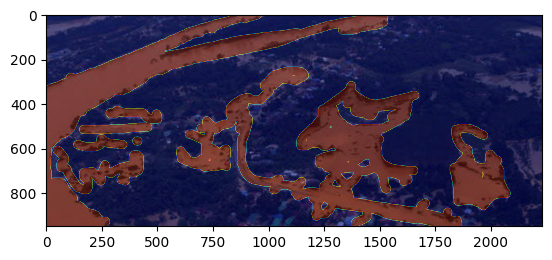

In [10]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

### Visualization ###
i = 150
ipath = '/content/drive/MyDrive/kaggle/FloodSegmentation/Image/' + df['image'][i]

img = mpimg.imread(ipath)
plt.imshow(img, cmap='gray')
mpath = '/content/drive/MyDrive/kaggle/FloodSegmentation/Mask/' + df['mask'][i]
mask = mpimg.imread(mpath)
print(mask.shape)
plt.imshow(mask, cmap='jet', alpha=0.4)

img.shape

## Dataset 정의, Dataloader

In [11]:
class custom_dataset():
    def __init__(self, input_paths, mask_paths, is_train):
        self.imgs = input_paths
        self.masks = mask_paths
        self.is_train = is_train

    def __getitem__(self, idx):
        img_path = '/content/drive/MyDrive/kaggle/FloodSegmentation/Image/' + self.imgs[idx]
        mask_path = '/content/drive/MyDrive/kaggle/FloodSegmentation/Mask/' + self.masks[idx]
        # Read image
        img = mpimg.imread(img_path)
        mask = mpimg.imread(mask_path)

        # 읽은 이미지를 transform
        if self.is_train:
          img = image_train_transform(image=img)['image']
        else:
          img = image_test_transform(image=img)['image']

        mask = image_mask_transform(image=mask)['image']

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [12]:
train_datasets = custom_dataset(img_train, mask_train, is_train=True)
val_datasets = custom_dataset(img_val, mask_val, is_train=False)
test_datasets = custom_dataset(img_test, mask_test, is_train=False)

trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=1, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_datasets, batch_size=1, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False, num_workers=2)

torch.Size([1, 512, 512])


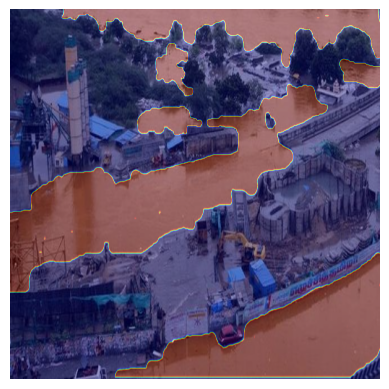

In [13]:
 ######### sample visualization #########
i = 0

sample_img, sample_label = next(iter(trainloader))
print(sample_label[0].shape)

sample_img = sample_img[0]
sample_img = np.transpose(sample_img, (1, 2, 0))
sample_label = sample_label[0]
sample_label = np.transpose(sample_label, (1, 2, 0))

showMask(sample_img, sample_label)

# Network

## U-net implementation

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2):
        super(UNet, self).__init__()

        self.double = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(512, 1024),
            nn.Dropout(p=0.5)
        ))
        self.upconv1 = UpConv(1024, 512)
        self.upconv2 = UpConv(512, 256)
        self.upconv3 = UpConv(256, 128)
        self.upconv4 = UpConv(128, 64)
        self.outconv = (nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1, bias=False)
        ))


    def forward(self, x):
      x1 = self.double(x)
      x2 = self.down1(x1)
      x3 = self.down2(x2)
      x4 = self.down3(x3)
      x5 = self.down4(x4)

      x = self.upconv1(x5, x4)
      x = self.double1(x)

      x = self.upconv2(x, x3)
      x = self.double2(x)

      x = self.upconv3(x, x2)
      x = self.double3(x)

      x = self.upconv4(x, x1)

      x = self.outconv(x)
      return x

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
      )

  def forward(self, x):
    return self.double_conv(x)

class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.down_conv = nn.Sequential(
      nn.MaxPool2d(kernel_size=2, stride=2),
      DoubleConv(in_channels, out_channels)
      )

  def forward(self, x):
    return self.down_conv(x)

class UpConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up_conv = nn.Sequential(
      nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
      )
    self.double_conv = DoubleConv(in_channels, out_channels)

  def forward(self, x, x_skip):
    x1 = self.up_conv(x)
    x = torch.cat([x1, x_skip], dim=1)
    x = self.double_conv(x)
    return x

print('Building Network!')
net = UNet()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

############ Parameters #############
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-5, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 30
#####################################

# sample_img, sample_label = next(iter(trainloader))
# output = net(sample_img)
# print(output, 'label: ', sample_label)

def train(epoch):
    print('\nTrain:')
    net.train()
    train_loss = 0
    for batch_idx, (images, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        images, targets = images.to(device), targets.to(device)
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if ((batch_idx+1) % (len(trainloader)/3) == 1) or batch_idx+ 1 == len(trainloader):
            print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))
    # print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(trainloader), train_loss/(batch_idx+1)))

def val(epoch):
    print('\nValidation:')
    net.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(valloader):

            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            scheduler.step()

            if ((batch_idx+1) % (len(valloader)/3) == 1) or batch_idx+ 1 == len(valloader):
                print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))
        # print('[%3d/%3d] | Loss: %.5f'%(batch_idx+1, len(valloader), val_loss/(batch_idx+1)))

for epoch in range(epochs):
    print('\nEpoch %d'%(epoch))
    train(epoch)
    val(epoch)

Building Network!

Epoch 0

Train:


TypeError: ignored

In [ ]:
test_loss = 0


with torch.no_grad():
    print('\nTest:')
    net.eval()
    for batch_idx, (images, labels) in enumerate(testloader):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        if batch_idx+1 == len(testloader):
            print('[%3d/%3d] | final_Loss: %f'%(batch_idx+1, len(testloader), test_loss/(batch_idx+1)))


Test:


KeyboardInterrupt: ignored

## Pretrained ResNet101

## Save Model parameters, Load

In [ ]:
######### Save Model ############
PATH = './UNet.pth'
torch.save(net.state_dict(), PATH)
#################################